In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
# import xgcm
# from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
# from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib.colors as colors
import seawater as sw
import math
import scipy.stats as stats
from matplotlib import axes
import xoak

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [17]:
# import dask, dask.distributed
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(cores=8,memory='60GB',processes=1,queue='large96:shared', walltime='6:00:00',interface='ib0',local_directory='$TMPDIR')
# client = dask.distributed.Client(cluster)
# cluster.scale(jobs=8)

In [ ]:
# client

In [3]:
def create_stat(model, year_start, year_finished = 2018): # UPDATED 09.09.2022 - > ONLY TYPED0
    
    """ 
        model == 0 > EXP05 elif == 1 EXP06
        typed == 0 > ACC / elif == 1 WHOLE REGION
    """
    
    folder = 'EXP05' if model == 0 else 'EXP06'
    
    with open(datapath + folder + '/detected/track_dict_' + str(year_start) + '0101_' + str(year_finished) + '1231_tracks_typed0.pickle', 'rb') as f:
        tracks = pickle.load(f)
    f.close()     
    
    eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)
    
    for i in eddy_stat.index:
        eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.loc[i][-1]) - pd.to_datetime(eddy_stat.time.loc[i][0])
    
    eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.terminated == True)]
    
    for i in eddy_stat.index:
        lat = [eddy_stat.loc[i, 'lat'][0], eddy_stat.loc[i, 'lat'][-1]]
        lon = [eddy_stat.loc[i, 'lon'][0], eddy_stat.loc[i, 'lon'][-1]]
        eddy_stat.loc[i, 'distance'] = sw.extras.dist(lat,lon)[0]
        #eddy_stat.loc[i, 'speed'] = eddy_stat.loc[i, 'distance'] / eddy_stat.loc[i, 'life_time']
        eddy_stat.loc[i, 'speed'] = (eddy_stat.loc[i, 'distance'] *1e5)/ (eddy_stat.loc[i, 'life_time'].days * 24 * 3600) # cm/s
#         eddy_stat.loc[i, 'angle'] = (sw.extras.dist(eddy_stat.loc[i, 'lat'], eddy_stat.loc[i, 'lon'])[1]).mean()
        eddy_stat.loc[i, 'area_mean'] = eddy_stat.loc[i, 'area'].mean()
        eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
        eddy_stat.loc[i, 'amp_mean'] = eddy_stat.loc[i, 'amp'].mean()
        eddy_stat.loc[i, 'amp_max'] = eddy_stat.loc[i, 'amp'].max()
        eddy_stat.loc[i, 'scale_mean'] = eddy_stat.loc[i, 'scale'].mean()
        eddy_stat.loc[i, 'scale_min'] = eddy_stat.loc[i, 'scale'].min()
        eddy_stat.loc[i, 'scale_max'] = eddy_stat.loc[i, 'scale'].max()
        eddy_stat.loc[i, 'year_i'] = pd.to_datetime(eddy_stat.time.loc[i][0]).year
        eddy_stat.loc[i, 'year_f'] = pd.to_datetime(eddy_stat.time.loc[i][-1]).year
    
    eddy_stat = eddy_stat.drop(labels=['lon','lat','amp','area','scale','exist_at_start','terminated'],axis=1)

    eddy_stat = eddy_stat.loc[(eddy_stat['life_time'].astype('timedelta64[D]') >= 30)]
    eddy_stat.loc[:, 'life_time'] = eddy_stat.loc[:, 'life_time'].astype('timedelta64[D]')
        
    eddy_stat.loc[:,'scale_mean'] *= 2
    eddy_stat.loc[:,'scale_max'] *= 2

    eddy_stat = eddy_stat.drop('time', axis=1)

    
    eddy_stat.to_pickle(path= datapath + folder + '/detected/stat_' + folder + '_acc_'+ str(year_start) + '_' + str(year_finished) +'.pkl')

    return eddy_stat

In [ ]:
# create_stat(model=1, year_start=1993, year_finished=2018)

### path to data

In [2]:
datapath = '/scratch/usr/shkifmmp/manusc/data/'

path_EXP05_old = '/scratch/usr/shkifmmp/master/data/ORION10/eddies_detect/acc/'

mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_nest_int_2d.nc')

In [3]:
mask_acc

<xarray.Dataset>
Dimensions:    (y: 627, x: 3562)
Coordinates:
    nav_lon    (y, x) float64 ...
    nav_lat    (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    mask_nest  (y, x) float64 ...

In [4]:
mask_plot = mask_acc.mask_nest.where(mask_acc.mask_nest ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat >= -65, other=0)

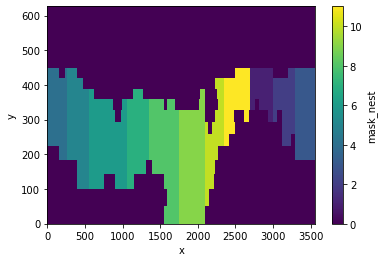

In [8]:
mask_acc.mask_nest.plot()

In [15]:
mask_plot.to_netcdf('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_acc.nc')

In [14]:
mask_plot.to_netcdf?

Signature: mask_plot.to_netcdf(*args, **kwargs) -> Union[bytes, ForwardRef('Delayed'), NoneType]
Docstring:
Write DataArray contents to a netCDF file.

All parameters are passed directly to :py:meth:`xarray.Dataset.to_netcdf`.

Notes
-----
Only xarray.Dataset objects can be written to netCDF files, so
the xarray.DataArray is converted to a xarray.Dataset object
containing a single variable. If the DataArray has no name, or if the
name is the same as a coordinate name, then it is given the name
``"__xarray_dataarray_variable__"``.

See Also
--------
Dataset.to_netcdf
File:      ~/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/xarray/core/dataarray.py
Type:      method


In [ ]:
mask_plot.to_netcdf()

In [5]:
def create_stat(model, typed, year_finished = 2018):
    
    """ 
        model == 0 > EXP05 elif == 1 EXP06
        typed == 0 > ACC / elif == 1 WHOLE REGION
    """
    
    folder = 'EXP05' if model == 0 else 'EXP06'
    
    if (typed == 0) & (model == 0):
        with open(path_EXP05_old + 'track_dict_19580101_' + str(year_finished) + '1231_tracks_typed' + str(typed) 
                  + '.pickle', 'rb') as f:
            tracks = pickle.load(f)
        f.close()
    else:
        with open(datapath + folder + '/detected/track_dict_19580101_' + str(year_finished) + '1231_tracks_typed' + str(typed) 
                  + '.pickle', 'rb') as f:
            tracks = pickle.load(f)
        f.close()     
    
    eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)
    
    for i in eddy_stat.index:
        eddy_stat.iloc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])
    
    eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.terminated == True)]
    
    for i in eddy_stat.index:
        lat = [eddy_stat.loc[i, 'lat'][0], eddy_stat.loc[i, 'lat'][-1]]
        lon = [eddy_stat.loc[i, 'lon'][0], eddy_stat.loc[i, 'lon'][-1]]
        eddy_stat.loc[i, 'distance'] = sw.extras.dist(lat,lon)[0]
        #eddy_stat.loc[i, 'speed'] = eddy_stat.loc[i, 'distance'] / eddy_stat.loc[i, 'life_time']
        eddy_stat.loc[i, 'speed'] = (eddy_stat.loc[i, 'distance'] *1e5)/ (eddy_stat.loc[i, 'life_time'].days * 24 * 3600) # cm/s
#         eddy_stat.loc[i, 'angle'] = (sw.extras.dist(eddy_stat.loc[i, 'lat'], eddy_stat.loc[i, 'lon'])[1]).mean()
        eddy_stat.loc[i, 'area_mean'] = eddy_stat.loc[i, 'area'].mean()
        eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
        eddy_stat.loc[i, 'amp_mean'] = eddy_stat.loc[i, 'amp'].mean()
        eddy_stat.loc[i, 'amp_max'] = eddy_stat.loc[i, 'amp'].max()
        eddy_stat.loc[i, 'scale_mean'] = eddy_stat.loc[i, 'scale'].mean()
        eddy_stat.loc[i, 'scale_min'] = eddy_stat.loc[i, 'scale'].min()
        eddy_stat.loc[i, 'scale_max'] = eddy_stat.loc[i, 'scale'].max()
        eddy_stat.loc[i, 'year_i'] = pd.to_datetime(eddy_stat.time.loc[i][0]).year
        eddy_stat.loc[i, 'year_f'] = pd.to_datetime(eddy_stat.time.loc[i][-1]).year
        
    eddy_stat.to_pickle(path= datapath + folder + '/detected/stat_' + folder + '_acc_1958_' + str(year_finished) +'.pkl')
    
    return eddy_stat

In [14]:
# folder='EXP06'
# year_finished=1996

# datapath + folder + '/detected/stat_' + folder + '_acc_1958_' + str(year_finished) +'.pkl'

'/scratch/usr/shkifmmp/manusc/data/EXP06/detected/stat_EXP06_acc_1958_1996.pkl'

In [4]:
def create_stat_old():
    with open(path_EXP05_old + 'case9_19780101_19971231_tracks_OW0.3_77.5_69.5.pickle', 'rb') as f:
            tracks = pickle.load(f)
    f.close()
    
    eddy_stat = pd.DataFrame.from_dict(tracks, orient = 'index').drop(['eddy_j', 'eddy_i'], axis=1)
    
    for i in eddy_stat.index:
        eddy_stat.loc[i, 'life_time'] = pd.to_datetime(eddy_stat.time.iloc[i][-1]) - pd.to_datetime(eddy_stat.time.iloc[i][0])
    
    eddy_stat = eddy_stat.loc[(eddy_stat['exist_at_start'] ==  False) & (eddy_stat.terminated == True)]
    
    for i in eddy_stat.index:
        lat = [eddy_stat.loc[i, 'lat'][0], eddy_stat.loc[i, 'lat'][-1]]
        lon = [eddy_stat.loc[i, 'lon'][0], eddy_stat.loc[i, 'lon'][-1]]
        eddy_stat.loc[i, 'distance'] = sw.extras.dist(lat,lon)[0]
        #eddy_stat.loc[i, 'speed'] = eddy_stat.loc[i, 'distance'] / eddy_stat.loc[i, 'life_time']
        eddy_stat.loc[i, 'speed'] = (eddy_stat.loc[i, 'distance'] *1e5)/ (eddy_stat.loc[i, 'life_time'].days * 24 * 3600) # cm/s
#         eddy_stat.loc[i, 'angle'] = (sw.extras.dist(eddy_stat.loc[i, 'lat'], eddy_stat.loc[i, 'lon'])[1]).mean()
        eddy_stat.loc[i, 'area_mean'] = eddy_stat.loc[i, 'area'].mean()
        eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
        eddy_stat.loc[i, 'amp_mean'] = eddy_stat.loc[i, 'amp'].mean()
        eddy_stat.loc[i, 'amp_max'] = eddy_stat.loc[i, 'amp'].max()
        eddy_stat.loc[i, 'area_max'] = eddy_stat.loc[i, 'area'].max()
        eddy_stat.loc[i, 'scale_mean'] = eddy_stat.loc[i, 'scale'].mean()
        eddy_stat.loc[i, 'scale_min'] = eddy_stat.loc[i, 'scale'].min()
        eddy_stat.loc[i, 'scale_max'] = eddy_stat.loc[i, 'scale'].max()
        
    return eddy_stat

In [ ]:
stat_06 = create_stat(model=1, typed=0, year_finished=2018)

In [ ]:
stat_05_78.to_pickle(path= datapath + 'EXP05/detected/stat_05_acc_1978_1997.pkl')

In [ ]:
for i in stat_05_78.index:
        stat_05_78.loc[i, 'year_i'] = pd.to_datetime(stat_05_78.time.iloc[i][0]).year
        stat_05_78.loc[i, 'year_f'] = pd.to_datetime(stat_05_78.time.iloc[i][-1]).year

In [ ]:
folder
stat_05_78.to_pickle(path= datapath + 'EXP05/detected/stat_05_acc_1978_1997.pkl')

### time series

### OBSERVATIONS
Get all eddies within the mask

In [28]:
# def adjust_longitude(long): # change to 0-360 longitude range FOR THE META DATA
#     func = lambda x: (-x + 180) % 360
#     return xr.apply_ufunc(func, long)

In [24]:
# meta20_dt = xr.open_dataset(datapath + 'obs/eddy_trajectory_dt_2.0_19930101_20200307.nc')

# track_eddy = xr.open_dataset(datapath + 'obs/trackeddy_V1-0_global_eddies.nc').drop(['area_gaussian','angle','angle_gaussian',
#                                                                                     'gaussian_spread_x','gaussian_spread_y', 'level'])

# t_eddy = track_eddy.where(track_eddy.maxima_loc_y<= -30, drop=True)

# t_eddy.to_netcdf(path= datapath + 'obs/trackeddy_30S.nc')

# meta = meta20_dt.where(meta20_dt.latitude<= -30, drop=True)

# meta.to_netcdf(path= datapath + 'obs/eddy_DT_30S.nc')

In [4]:
# meta = xr.open_dataset(datapath + 'obs/eddy_DT_30S.nc')

In [16]:
# meta = meta.where(meta.latitude>= -67.9824, drop=True)

In [17]:
# meta.to_netcdf(path= datapath + 'obs/eddy_DT_30S_67S.nc')

In [ ]:
# x = np.arange(-47,372,1) # change to 0-360 longitude range
# y = (-x + 180) % 360
# plt.plot(x,y)

In [ ]:
# meta.update({'longitude': adjust_longitude(meta.longitude)})

In [47]:
# meta.to_netcdf(path= datapath + 'obs/eddy_DT_30S.nc')

In [44]:
track_e_S = xr.open_dataset(datapath + 'obs/trackeddy_30S.nc')

In [52]:
track_e

<xarray.Dataset>
Dimensions:            (obs: 4974084)
Coordinates:
    nav_lon            (obs) float64 ...
    nav_lat            (obs) float32 ...
Dimensions without coordinates: obs
Data variables:
    neddy              (obs) float64 2.764e+07 2.934e+07 ... 1.028e+07 1.028e+07
    time_tracking      (obs) timedelta64[ns] ...
    center_mass_loc_x  (obs) float64 ...
    center_mass_loc_y  (obs) float64 ...
    area_eddy          (obs) float64 ...
    longitude          (obs) float64 ...
    latitude           (obs) float64 ...
    eddy_amplitude     (obs) float64 ...
    time               (obs) datetime64[ns] ...
Attributes: (12/22)
    summary:              Eddy atlas from gridded data AVISO+ over global ocean
    comment:              Surface product; mesoscale eddies
    date_created:         2019-08-5T15:51Z
    time_coverage_start:  1993-01-01T00:00:00Z
    time_coverage_end:    2017-12-31T00:00:00Z
    Conventions:          CF-1.7, ACDD-1.3
    ...                   ...
    product_version:      1.0
    institution:          Australian National University - ANU
    publisher_email:      paola.petrelli@utas.edu.au
    id:                   http://doi.org/10.25914/5cb6859e4df3e
    history:              Wed Sep 11 15:29:21 2019: ncap2 -s neddy=double(ned...
    NCO:                  netCDF Operators version 4.7.7 (Homepage = http://n...

In [51]:
track_e.groupby('neddy')

DatasetGroupBy, grouped over 'neddy'
4974084 groups with labels 3.0, 28.0, ..., 3.72e+07, 3.72e+07.

In [16]:
# # make mask with lon 0-360
# mask_test = mask_plot.where(mask_plot.nav_lon <=360, drop=True)

# mask_test_aux = mask_plot.where(mask_plot.nav_lon >360, drop=True)

# mask_test_aux.coords['nav_lon'].values = mask_test_aux.nav_lon.values - 360

# mask_obs= xr.concat([mask_test_aux, mask_test], 'x')

In [9]:
# track_e = track_e.rename({'maxima_loc_x': 'longitude', 'maxima_loc_y': 'latitude'})

In [ ]:
# meta.set_coords({'latitude': meta.latitude, 'longitude': meta.longitude})

In [ ]:
# meta.sel('latitude' = mask_obs)

In [17]:
# mask_obs.xoak.set_index(['nav_lon','nav_lat'], "sklearn_geo_balltree")

In [20]:
# lati = meta.latitude.compute()

In [21]:
# long = meta.longitude.compute()

In [24]:
# %%time
# meta_xo = mask_obs.xoak.sel(nav_lat= meta.latitude, nav_lon=meta.longitude)

CPU times: user 19min 53s, sys: 449 ms, total: 19min 53s
Wall time: 19min 56s


In [25]:
# meta_xo = xr.DataArray(data=meta_xo, dims=['obs'])

# meta = meta.where(meta_xo, drop=True)

# meta.to_netcdf(path=datapath + 'obs/meta_xoak.nc')

In [27]:
# meta.to_netcdf(path=datapath + 'obs/meta_xoak.nc')

In [42]:
# track_e = track_e.reset_index('time').reset_coords('time_').rename({'time': 'obs'})

In [45]:
# track_e = track_e.rename({'time_': 'time'})

In [18]:
# %%time
# track_xo = mask_obs.xoak.sel(nav_lat= track_e.latitude, nav_lon=track_e.longitude)

CPU times: user 26min 32s, sys: 820 ms, total: 26min 33s
Wall time: 26min 36s


In [50]:
# track_xo = track_xo.rename({'time': 'obs'})

In [51]:
# track_e = track_e.where(track_xo, drop=True)

In [ ]:
# meta.to_netcdf(path=datapath + 'obs/meta_xoak.nc')

In [52]:
# track_e.to_netcdf(path=datapath + 'obs/track_e_xoak.nc')

In [ ]:
# track_e_xo = mask_obs.xoak.sel(nav_lat= track_e.latitude, nav_lon=track_e.longitude).values

In [ ]:
# # BEFORE RUNNING: CHANNGE THE 'OBS' TO THE EQUIVALENT IN TRACK_E !!!
# track_e_xo = xr.DataArray(data=track_e_xo, dims=['obs'])

# track_e = meta.where(track_e_xo, drop=True)

# track_e.to_netcdf(path=path_obs + 'track_e_xoak.nc')

In [47]:
# (pd.to_datetime(meta.where(meta.track == 0, drop = True).time[-1].values) - pd.to_datetime(meta.where(meta.track == 0, drop = True).time[0].values))

Timedelta('73 days 00:00:00')

In [ ]:
# (pd.to_datetime(meta20_dt.where(meta20_dt.track == 1,drop=True).groupby('track').first().time) - pd.to_datetime(meta20_dt.where(meta20_dt.track == 1,drop=True).groupby('track').last().time)).astype().astype

In [29]:
# track_e = track_e.rename({'maxima_loc_x': 'longitude',
#                'maxima_loc_y': 'latitude',
#                'eddy_amplitude': 'amplitude',
#                'area_eddy': 'area'})

In [ ]:
# meta.rename({})

In [21]:
# track_e.isel(time=200).time_tracking.values.astype('timedelta64[D]')

numpy.timedelta64(1,'D')

In [55]:
meta = xr.open_dataset(datapath + 'obs/meta_xoak.nc')

In [ ]:
meta.groupby('track').max()[0:10]

In [113]:
test = pd.to_datetime(meta.isel(obs=slice(100,200)).groupby('track').last().time) - pd.to_datetime(meta.isel(obs=slice(100,200)).groupby('track').first().time)

In [100]:
lat = [meta.isel(obs=slice(100,200)).groupby('track').first().latitude.values, meta.isel(obs=slice(100,200)).groupby('track').last().latitude.values]

In [89]:
lon = [meta.isel(obs=slice(100,200)).groupby('track').first().longitude.values, meta.isel(obs=slice(100,200)).groupby('track').last().longitude]

In [125]:
distance = sw.extras.dist(lat,lon)[0][0]

In [117]:
test2 = xr.Dataset(data_vars={'test': ('track', test),
    'lala': ('track', distance)})

In [8]:
track_e = xr.open_dataset(datapath + 'obs/track_e_xoak.nc')

In [18]:
np.diff(track_e.neddy[0:100])

array([  1702596.,    261867.,  -5325450., -18336815.,   7811469.,
        -4445035.,  -4956784.,  17271067.,  -1058509.,    617924.,
       -15555025.,   7162192.,  16077206., -24121920.,  30910060.,
       -12877918.,   4947982., -16649370.,  16092484., -22509700.,
        19709014.,   1321458., -13818855.,  24255759.,    601098.,
        -1860760.,  -7526751.,  -4255898.,  -1548935., -18819421.,
        23015171., -20369323.,  11122772.,  19082341., -19820553.,
        12025286., -12152517.,  21021040., -17738006.,  13187786.,
        -3138491.,   3314651., -14143394.,   4831270.,  -9853073.,
        21639963.,  -6263548.,   8423554., -33790439.,  31242445.,
        -2998712.,   1657501., -26976883.,  29962641., -15874723.,
        -8251849.,  -4306765.,  -5564616.,   1772733.,  15480557.,
        14889278., -20864317.,   4152881.,   5037630., -18207487.,
        -4259502.,  35086224.,  -2204675., -16657699.,  -7579969.,
         -909840.,   2188004.,  11523639.,  -5913331., -138475

In [37]:
track_e.time[3]

<xarray.DataArray 'time' ()>
array('2009-03-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    nav_lon  float64 ...
    nav_lat  float32 ...
Attributes:
    standard_name:  time

In [4]:
# track_e.time[0:100]

In [127]:
# first get eddies within area
def obs_proc_meta(data):
    first = data.groupby('track').first()
    last = data.groupby('track').last()
    mean = data.groupby('track').mean()
    maxi = data.groupby('track').max()
    
    life_time = pd.to_datetime(last.time) - pd.to_datetime(first.time)
    amp_max= maxi.amplitude
    speed = mean.speed_average
    scale_max = maxi.speed_radius * 1e-3 * 2
    lat = [first.latitude, last.latitude]
    lon = [first.longitude, last.longitude]
    distance = sw.extras.dist(lat,lon)[0][0]
    
    data_pos = xr.Dataset(data_vars={'life_time': ('track', life_time),
                         'amp_max': ('track', amp_max),
                         'speed': ('track', speed),
                         'distance': ('track', distance),
                         'scale_max': ('track', scale_max)})
    
    return data_pos

In [137]:
first = meta.groupby('track').first()
last = meta.groupby('track').last()
mean = meta.groupby('track').mean()
maxi = meta.groupby('track').max()

In [138]:
life_time_me = pd.to_datetime(last.time) - pd.to_datetime(first.time)

In [139]:
amp_max_me= maxi.amplitude

In [140]:
speed_me = mean.speed_average

In [141]:
scale_max_me = maxi.speed_radius * 1e-3 * 2

In [142]:
lat_me = [first.latitude, last.latitude]

In [143]:
lon_me = [first.longitude, last.longitude]

In [176]:
distance_me = sw.extras.dist(lat=lat_t, lon=lon_t)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
# first.to_netcdf(path= datapath + 'obs/meta_post_first.nc')
# last.to_netcdf(path= datapath + 'obs/meta_post_last.nc')
# mean.to_netcdf(path= datapath + 'obs/meta_post_mean.nc')
# maxi.to_netcdf(path= datapath + 'obs/meta_post_maxi.nc')
life_time_me.to_netcdf(path= datapath + 'obs/meta_post_lifetime.nc')
# amp_max_me.to_netcdf(path= datapath + 'obs/meta_post_amp.nc')
# speed_me.to_netcdf(path= datapath + 'obs/meta_post_speed.nc')
# scale_max_me.to_netcdf(path= datapath + 'obs/meta_post_scale.nc')
lat_me.to_netcdf(path= datapath + 'obs/meta_post_lat.nc')
lon_me.to_netcdf(path= datapath + 'obs/meta_post_lon.nc')

In [5]:
lifetime_m = xr.open_dataset(glob(datapath + 'obs/meta_pos*lifetime*')[0])

amp_m = xr.open_dataset(glob(datapath + 'obs/meta_pos*amp*')[0])

lat1_m = xr.open_dataset(glob(datapath + 'obs/meta_pos*lat1*')[0])

lat2_m = xr.open_dataset(glob(datapath + 'obs/meta_pos*lat2*')[0])

lon1_m = xr.open_dataset(glob(datapath + 'obs/meta_pos*lon1*')[0])
lon2_m = xr.open_dataset(glob(datapath + 'obs/meta_pos*lon2*')[0])

scale = xr.open_dataset(glob(datapath + 'obs/meta_pos*scale*')[0])

speed = xr.open_dataset(glob(datapath + 'obs/meta_pos*speed*')[0])

In [140]:
lifetime_m = lifetime_m.rename({'__xarray_dataarray_variable__': 'lifetime'} )

In [159]:
lifetime_m.coords['track'] = speed.coords['track']

In [165]:
meta = meta.update({'distance': ('track', distance)})

In [161]:
meta = xr.merge([scale, speed, amp_m, lifetime_m])

In [163]:
distance

array([457.7756 , 285.90952, 506.30096, ..., 105.72132,  74.04175,
        75.29008], dtype=float32)

In [76]:
lon = np.column_stack((lon1_m.longitude.values, lon2_m.longitude.values))

In [75]:
lat = np.column_stack((lat1_m.latitude.values, lat2_m.latitude.values))

In [97]:
distance = list(map(sw.extras.dist,lat, lon))

In [168]:
meta.to_netcdf(path= datapath + 'obs/meta_postproc_complete.nc')

In [113]:
distance = np.array(distance)

In [132]:
distance = np.squeeze((np.hsplit(distance,2)))

In [136]:
distance = distance[0]

In [85]:
distance_me = sw.extras.dist(lat=lat, lon=lon)[0]

In [53]:
[lat1_m.latitude.values, lat2_m.latitude.values]

[array([-55.9151, -45.7119, -54.4664, ..., -57.3629, -47.9334, -53.3901],
       dtype=float32),
 array([-55.9495, -43.9774, -54.6469, ..., -58.1705, -47.2891, -52.9078],
       dtype=float32)]

[(array([ 9647.67  , 10068.203 ,  5868.9243, ...,  1331.1963,  9031.344 ,
         12251.712 ], dtype=float32),
  array([ 173.2511   , -174.45537  ,    4.7876573, ...,    2.1847835,
          173.3376   ,   -2.8367794], dtype=float32)),
 (array([ 9513.526 , 10623.575 ,  6417.0566, ...,  1191.5409,  8955.19  ,
         12437.167 ], dtype=float32),
  array([ 171.96161  , -173.59242  ,    5.2761893, ...,   -2.0378227,
          172.24014  ,   -2.877476 ], dtype=float32))]

In [197]:
xr.DataArray(data= lon_me[1], dims='track').to_netcdf(path= datapath + 'obs/meta_post_lon2.nc')

In [ ]:
meta_pos.to_netcdf(path=datapath + 'obs/meta_postproc.nc')